# Computer Vision CSCI-GA.2272-001 Assignment 1

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch, modify this ipython notebook

To install PyTorch, follow instructions at http://pytorch.org/

Please email your assignment to the graders: Yi-Hsiang Kao (ykh342@nyu.edu) and Anshul Sharma (as10950@nyu.edu).

## Warmup [10%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Training a Single Layer Network on MNIST [20%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 50,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [20%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [50%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

- Give a breakdown of the parameters within the above model, and the overall number.

In [45]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [56]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01     # learning rate

In [57]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet

#set train_set shuffle= False for 50 example question

if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


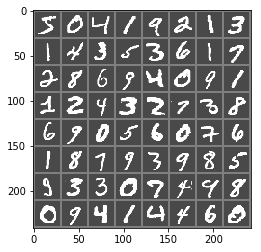

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


In [37]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [59]:
## network and optimizer including hidden layer
if dataset == 'mnist':
    num_inputs = 784
    num_hidden = 1000
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Nets(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Nets, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs),
            nn.Tanh()
        )

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.model(input)
        return output

network2 = Nets(num_inputs, num_outputs)
optimizer = optim.SGD(network2.parameters(), lr=lr)

In [44]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = network(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




In [60]:
#train_test with model including hidden layer
def train(epoch):
    network2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network2(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network2.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = network2(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




Train Epoch: 1 [0/60000 (0%)]	Loss: 2.389833
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.027910
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.592861
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.675647
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.546371
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.700097
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.564533
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.565457
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.787396
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.578597

Test set: Average loss: 1.5560, Accuracy: 5302/10000 (53%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.624972
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.545598
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.609658
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.634854
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.557561
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.583455
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.687471
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.649336
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.606678
T

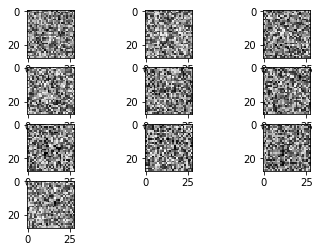

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
for epoch in range(1, epochs + 1):
    train(epoch)
    test()
#change network name as needed when plotting
fig=plt.figure()
for i in range(0,10):
    ax1 = fig.add_subplot(4,3,i+1)
    ax1.imshow(network.linear.weight.data.numpy()[i].reshape([28,28]),cmap=plt.cm.binary)


In [7]:
#CNN network and optimizer

epochs_c=20
lr_c=0.01



if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10

class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=5)
        self.conv2=nn.Conv2d(16,128,kernel_size=5)
        self.fc1 = nn.Linear(128 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(torch.tanh(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

network_CNN = CNN_Net()
print(network_CNN)
optimizer = optim.SGD(network_CNN.parameters(), lr=lr_c)

CNN_Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [8]:
def train_CNN(epoch):
    network_CNN.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network_CNN(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_CNN():
    network_CNN.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = network_CNN(data)
            test_loss += F.cross_entropy(output, target, reduction="sum").data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
for epoch in range(1, epochs_c + 1):
    train_CNN(epoch)
    test_CNN()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.298880
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.165870
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.036782
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.023883
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.003274
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.930639
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.011447
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.748299

Test set: Average loss: 1.7757, Accuracy: 3781/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.839171
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.693297
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.533852
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.669518
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.707779
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.629963
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.759724
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.529496

Test set: Average loss: 1.5774, Accuracy: 4375/10000 (43%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.589650
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.519


Test set: Average loss: 0.9390, Accuracy: 6698/10000 (66%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.840357
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.758153
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.694850
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.831756
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.756537
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.890631
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.834639
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.851517

Test set: Average loss: 0.9294, Accuracy: 6743/10000 (67%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.817731
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.734332
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.677254
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.805924
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.738089
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.865306
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.814538
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.836976

Test set: Average loss: 0.9213, Accuracy: 6781/10000 (67%)



In [66]:
import visdom

visdom.Visdom().images(network_CNN.conv1.weight.data)

'window_36aa4a61b1d0d2'